# Cleaning

In [5]:
# Importing
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

path = "../data/raw/houses_moreinfo.csv"

df = pd.read_csv(path)


In [6]:
# Change name of places to lower
def format_name(x):
    return x.lower()

df["city"] = df.city.apply(format_name)
df["district"] = df.district.apply(format_name)
df["province"] = df.province.apply(format_name)

# Substitute 0 for Nan
df.replace(0, np.nan, inplace=True)

# Drop rows with life_annuity == 1
life_annuity = df.query("life_annuity == 1").index
df.drop(life_annuity, inplace=True)

# Drops rows with NaN in price
df.dropna(subset=['price'], inplace=True)

# Drops columns that are useless or with a big NaN ratio (>90%)
df.drop(['life_annuity', 'has_balcony', "sale_type", "type_sale", "furnished", "heating" ], axis=1, inplace=True)


# Drop subtypes that are not monoliving spaces
bad_columns = df["subtype"].isin(["CASTLE","APARTMENT_BLOCK", "MIXED_USE_BUILDING", "MANSION", "OTHER_PROPERTY", "MANOR_HOUSE"])
df = df[~bad_columns]

# Drop empty living
df.dropna(subset=['living_area'], inplace=True)
zero_rows = df["living_area"] == 0 
df = df[~zero_rows]

# Drop empty total_area
df.dropna(subset=['area_total'], inplace=True)
zero_rows1 = df["area_total"] == 0
df_clean = df[~zero_rows1]


In [ ]:
# Exporting as a new CSV
# df_clean.to_csv("Cleaned_2.csv", sep=',', index=False, encoding='utf-8')

# Start exploring

In [7]:
df_clean.shape


(30554, 27)

In [8]:
# Seeing missing values
percent_missing = df_clean.isnull().sum() * 100 / len(df)
percent_missing

id                     0.000000
city                   0.000000
postal_code            0.000000
district               0.000000
province               0.000000
price                  0.000000
subtype                0.000000
state_construction    26.003142
living_area            0.000000
terrace_area          73.322642
garden_area           69.097336
rooms                 70.671598
bedrooms               0.644760
bathrooms              8.912090
livingroom_surface    55.288997
kitchen_surface       59.111737
facades               19.382078
has_garden            62.086797
kitchen               40.194410
fireplace             80.146626
swimmingpool          96.337632
has_terrace           47.617333
has_attic             70.079204
has_basement          60.227793
construction_year     39.785298
epc                   17.951823
area_total             0.000000
dtype: float64

### Usefull functions

In [9]:
def IQR (column) -> float:
    """Compute lowerlimit and upperlimit to trim outliers via Tukey's fence"""
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    #quartiles = df[column].quantile([0.25, 0.75])
    iqr = Q3 - Q1
    lowerlimit = Q1 - 1.5*iqr
    upperlimit = Q3 + 1.5*iqr

    return lowerlimit, upperlimit

def thousants_point(x: int) -> str:
    """Adds point to separate thousant in text.
    Args:
        x: number that will take the thousant point
        n: number"""
    return str('{:,}'.format(round(x)).replace(',','.'))

### Usefull new columns

In [10]:
df_clean ["Price per Living Area"] = df_clean ["price"]/df_clean ["living_area"]
df_clean ["Price per Total Area"] = df_clean ["price"]/df_clean ["area_total"]
df_clean ["Outside area"] = df_clean["garden_area"] + df_clean["terrace_area"]


## Cleaning outliers

In [11]:
# Cleans price outliers
# Excludes biddings (per immoweb exploration min price of houses is 40k)
mask_price = df_clean['price']> 40000
no_outliers = df_clean[mask_price]

# Cleans the price outliers via IQR function
lowerlimit, upperlimit  = IQR(no_outliers["price"])
no_outliers = no_outliers[no_outliers['price'].between(lowerlimit, upperlimit)]


# Cleans total_area outliers
# Excludes small properties that are garages under wrong input on immoweb
mask_total_area = no_outliers['area_total']> 50
no_outliers = no_outliers[mask_total_area]

# Excludes per IQR
lowerlimit_tarea, upperlimit_tarea  = IQR(df["area_total"])
no_outliers = no_outliers[no_outliers['area_total'].between(lowerlimit_tarea, upperlimit_tarea)]

# Cleaning living_area outliers
# Excludes again garages and wrong inputs that fall under living_area
mask_living = no_outliers['living_area']> 50
no_outliers = no_outliers[mask_living]

# Exclude outliers per IQR
lowerlimit_larea, upperlimit_larea  = IQR(df["living_area"])
no_outliers = no_outliers[no_outliers['living_area'].between(lowerlimit_larea, upperlimit_larea)]

## Graph number of properties per price

In [13]:

# GRAPH NUMBER OF PROPERTIES PER PRICE
# Sets up vertical lines 
# Define numerical values for vertical lines
no_outliers_q1 = no_outliers["price"].quantile(0.25)
no_outliers_q3 = no_outliers["price"].quantile(0.75)
average_price_no_outliers = no_outliers.price.mean()
# Defines text for vertical lines
text_average = "Avg € " + thousants_point(average_price_no_outliers)
text_q1 = "Q1 € " + thousants_point(no_outliers_q1)
text_q3 = "Q3 € " + thousants_point(no_outliers_q3)

# Defines histogram plot
# Starts setting up histogram of prices
fig = px.histogram(no_outliers, x="price", nbins=40, labels={'price': "Price (€)"}) 
fig.update_layout(bargap=0.2)

# Adds vertical lines that are added
fig.add_vline(x=average_price_no_outliers, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average, annotation_position="top")
fig.add_vline(x=no_outliers_q1, line_dash = 'dash', line_color = 'green', annotation_text= text_q1, annotation_position="top left")
fig.add_vline(x=no_outliers_q3, line_dash = 'dash', line_color = 'green', annotation_text= text_q3, annotation_position="top right")

# Makes it a bit more pretty and clean
fig.update_layout(
    title = "Pricing distribution", 
    title_font=dict(size=20,
                    color='#1F449C',
                    family='Arial'),
    title_x=0.1,  
)

# Display plot
fig.show()



## Graph number of houses per price/m2

In [18]:
# GRAPH NUMBER OF HOUSES PER PRICE/(SQM)
# Subsetting dataframe for variables to be explored
price_area = no_outliers[["id", "Price per Living Area"]]


# Cleans data from outliers via Tukey IQR method
lowerlimit, upperlimit  = IQR(price_area["Price per Living Area"])
price_area = price_area[price_area["Price per Living Area"].between(lowerlimit, upperlimit)]

# Sets up info to be added to plot (average) and its text
average_price_living_area = price_area["Price per Living Area"].mean()
text_average_living = "Avg € " + thousants_point(average_price_living_area) + "/sqm"

# Starts setting up the histogram
fig = px.histogram(price_area, x="Price per Living Area", nbins = 50, title="Number of houses versus price per sqm", labels={"Price per Living Area": "Price per area (€ / m²)"}) 
fig.add_vline(x=average_price_living_area, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average_living, annotation_position="top")
fig.update_layout(bargap=0.2)

# Displays the plot
fig.show()

## Graph scatter plot price per living area

In [23]:
# SCATTER PLOT FOR PRICE AND TOTAL AREA

fig = px.scatter(no_outliers, x="price", y="area_total",  labels = {"area_total" : "Surface Area (sqm)", "price": "Price (€)"},trendline="lowess", trendline_color_override="red", title= "Price growth in relation to Surface Area" )
fig.update_traces(marker=dict(size=2.5),
                  selector=dict(mode='markers'))
fig.show()


## Living area per price

In [25]:

## GRAPH LIVING AREA PER PRICE

fig = px.scatter(no_outliers, x="price", y="living_area",  labels = {"living_area" : "Living Area (sqm)", "price": "Price (€)"},trendline="lowess", trendline_color_override="red", title = "Price growth per Living Area")
fig.update_traces(marker=dict(size=2.5),
                  selector=dict(mode='markers'))
fig.show()

## Graph avg house price versus year and EPC

In [32]:
#GRAPH HOUSE PRICE AND EPC

# Selecting only columns with EPC correctly inputed
mask_epc = no_outliers['epc'].isin(["A++", "A+", "A", "B", "C", "D", "E", "F", "G"])
compare_epc_mask= no_outliers[mask_epc]

# Group EPCS A
group_epc = {"A++": "As", "A+" : "As", "A" : "As"}
epc_grouped= compare_epc_mask.replace({"epc":group_epc})

# Grouping interesting variables per EPC type
compare_epc = epc_grouped.groupby('epc', as_index=False)[["price",'construction_year']].mean().round()

# Starts bar plot to compare EPC, average pricing and construction year
fig = px.bar(compare_epc, x='epc', y='price',  title="Avg house price and construction year per EPC", labels = {'price': "Price (€)", 'epc': "EPC", "construction_year": "Avg year of construction"}, color_continuous_scale = 'Turbo', color= "construction_year")
fig.update_xaxes(categoryorder='array', categoryarray= ["As", 'B', 'C', 'D', 'E', 'F', 'G'])
fig.show()

### GRAPH DISTRIBUTION OF EPC AND PRICE

In [37]:
# GRAPH DISTRIBUTION OF PRICE PER EPC 

# Filters for bigger districts
districts = ["antwerp", "halle-vilvoorde", "gent", "liège", "turnhout" , "leuven", "nivelles", "aalst", "kortrijk", "charleroi" ]

# Select columns to do the correlation
epc_grou_dist = epc_grouped[epc_grouped['district'].isin(districts)]

fig = px.box(epc_grouped, hover_data=["price"],  x="price", y="epc", title="Price versus EPC on the top 10 districts in property volume", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")

fig.update_yaxes(categoryorder='array', categoryarray= ["G", "F","E","D","C","B","As"])
fig = fig.update_layout(showlegend=False)


fig.show()

In [39]:
# GRAPH EPC VERSUS PRICE VERSUS NUMBER OF PROPERTIES

def find_range (x) -> str:
    """Returns string with price range, given an x price"""
    if x >= 600000:
        return "600k or over"
    elif x < 600000 and x>400000:
        return "400k to 600k"
    elif x<=400000 and x>200000:
        return "200k to 400k"
    else:
        return "200k or under"

# Defines new columns to classify price in a range
stacked_price = epc_grouped[["epc", "price"]]
stacked_price["Price Range"] = stacked_price.price.apply(find_range)
stacked_price.head()
stacked_price.sort_values("Price Range")

# Starts setting up histogram of price ranges, EPC and volume of properties
fig = px.histogram(stacked_price, x="epc", labels={'epc': "EPC"}, color= "Price Range", barmode = "group",title= "Number of properties per EPC and price range" ,  category_orders={"Price Range": ["200k or under", "200k to 400k", "400k to 600k","600k or over"]}) 
fig.update_layout(bargap=0.2)
fig.update_xaxes(categoryorder='array', categoryarray= ["As", "B","C","D","E","F","G"])

# Display plot
fig.show()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_60508\1761113636.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Distribution of price per living area

In [50]:
# GRAPH DISTRIBUTION OF PRICE PER LIVING AREA

# Defines range for size of living area
def range_living(x):
    """Returns string that classifies a living_area size (x) into a range"""
    if x >= 400:
        return "400 sqm and over"
    elif x >= 300 and x<400:
        return "300sqm to 400 sqm"
    elif x >=200 and x < 300:
        return "200sqm to 300 sqm"
    elif x >=100 and x < 200:
        return "100sqm to 200 sqm"
    else:
        return "under 100sqm"
    

# Filters for bigger districts
#districts = ["antwerp", "halle-vilvoorde", "gent", "liège", "turnhout" , "leuven", "nivelles", "aalst", "kortrijk", "charleroi" ]

# Select columns to do the correlation
living_grou_dist = no_outliers[no_outliers['district'].isin(districts)]

living_grou_dist["Range Living Área"] = living_grou_dist.living_area.apply(range_living)
living_grou_dist.head()

fig = px.box(living_grou_dist, x="price", y="Range Living Área", title = "Price per Living Area (sqm) for the top 10 districts in volume of property",  color="Range Living Área", labels = {"price": "Price (€)", "Range Living Área": "Living Area (sqm)"})

fig.update_yaxes(categoryorder='array', categoryarray= ["under 100sqm", "100sqm to 200 sqm","200sqm to 300 sqm","300sqm to 400 sqm","400 sqm and over"])
fig = fig.update_layout(showlegend=False)


fig.show()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_60508\533413330.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### GRAPH PRICE EVOLUTION PER EPC AND LIVING AREA

In [62]:
# GRAPH PRICE EVOLUTION EPC LIVING AREA
fig = px.scatter(epc_grouped, x="living_area", y="price", color='epc', labels = {'epc': "EPC", "price": "Price (€)", "living_area":"Living Area (sqm)" }, trendline="lowess", category_orders={"epc":["As", "B", "C", "D", "E", "F", "G"]}, title = "Price per Living Area and EPC")
fig.update_traces(marker_size=2)
fig.update_traces(visible=False, selector=dict(mode="markers"))
fig.update_traces(showlegend=True, selector=dict(mode="lines"))


fig.show()

### CORRELATION MAPS

#### TURN CATEGORICAL VARIABLES INTO QUANTITATIVE

C:\Users\t_dei\AppData\Local\Temp\ipykernel_60508\2820752355.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



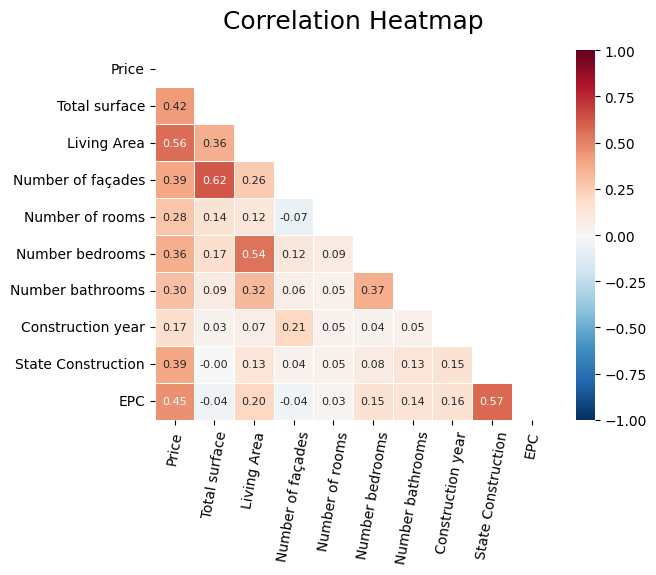

In [63]:
# Designates a numeric scale for qualitative data
epc_sub= {"A++":8, "A+":7, "A":6,"B":5,"C":4,"D":3,"E":2,"F": 1,"G":0}
state_sub = {"AS_NEW":3, "JUST_RENOVATED":2, "GOOD":2, "TO_BE_DONE_UP":1, "TO_RENOVATE":1, "TO_RESTORE":1 }

# Replaces string values for the numeric scale created
correlation_var= no_outliers.replace({"epc":epc_sub, "state_construction": state_sub})

# Filters out rows that have invalid input that were not able to be substituted before
correlation_var = correlation_var[correlation_var['epc'].isin([0,1,2,3,4,5,6,7,8, np.nan])]
correlation_var = correlation_var[correlation_var["state_construction"].isin([0,1,2,3,4,5, np.nan])]

# Filters for bigger districts
districts = ["antwerp", "halle-vilvoorde", "gent", "liège", "turnhout" , "leuven", "nivelles", "aalst", "kortrijk", "charleroi" ]
correlation_var = correlation_var[correlation_var['district'].isin(districts)]


# Correct names of columns before plotting to something prettier
correct_names = {"price": "Price", 
                "living_area": "Living Area", 
                "state_construction": "State Construction", 
                "construction_year":"Construction year", 
                "epc": "EPC",
                "fireplace": "Has Fireplace",
                "facades": "Number of façades",
                "swimmingpool": "Has swimmingpool",
                "kitchen": "Has equipped kitchen",
                "area_total": "Total surface",
                "rooms": "Number of rooms",
                "bedrooms":"Number bedrooms",
                "bathrooms": "Number bathrooms",
                "livingroom_surface": "Livingroom surface",
                "kitchen_surface":"Kitchen Surface"
                }
correlation_var.rename(columns= correct_names, inplace = True)

# FIRST CORRELATION HEATMAP

# Select variables to be correlated
correlation1= correlation_var[["Price", "Total surface", "Living Area", "Number of façades", "Number of rooms", "Number bedrooms", "Number bathrooms", "Construction year",  "State Construction", "EPC" ]]
# Creates dataframe of the correlations
correlation_graph_1 = correlation1.corr()

# Creates the heatmap of correlations in matrix form via seaborn
# Creates mask with numeric matrix that will exclude the upper half of the matrix
mask = np.triu(np.ones_like(correlation_graph_1 , dtype=bool))

# Creates the heatmap and plots it
heatmap = sns.heatmap(correlation_graph_1 , mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r', fmt=".2f", linewidth=.5, annot_kws = {"fontsize":8})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
heatmap.tick_params(axis='x', rotation=80)

### Correlation of booleand data

C:\Users\t_dei\AppData\Local\Temp\ipykernel_60508\2159768380.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t_dei\AppData\Local\Temp\ipykernel_60508\2159768380.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t_dei\AppData\Local\Temp\ipykernel_60508\2159768380.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Text(0.5, 1.0, 'Correlation Heatmap')

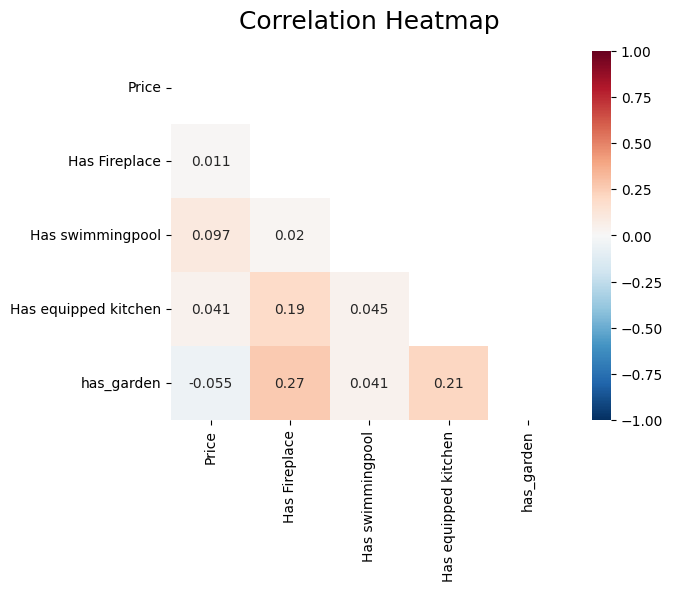

In [60]:
# Select columns to do the correlation
correlation2= correlation_var[["Price", "Has Fireplace", "Has swimmingpool","Has equipped kitchen", "has_garden"]]

# Corrects any mistake on input that is not 0 or 1
correlation2['Has Fireplace'] = correlation2['Has Fireplace'].fillna(0)
correlation2['Has swimmingpool'] = correlation2['Has swimmingpool'].fillna(0)
correlation2['Has equipped kitchen'] = correlation2['Has equipped kitchen'].fillna(0)
correlation2['has_garden'] = correlation2['has_garden'].fillna(0)

# Creates dataframe of the correlations
correlation_graph_2 = correlation2.corr(method ='pearson')

# Creates the heatmap of correlations in matrix form via seaborn
# Creates mask with numeric matrix that will exclude the upper half of the matrix
mask = np.triu(np.ones_like(correlation_graph_2  , dtype=bool))

# Creates the heatmap and plots it
heatmap = sns.heatmap(correlation_graph_2  , mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

### DEPRECATED GRAPHS

In [52]:
# Selecting rows with valid data for construction state
type_state = ["AS_NEW","JUST_RENOVATED", "GOOD", "TO_BE_DONE_UP", "TO_RENOVATE", "TO_RESTORE"]
mask_state_construction = no_outliers['state_construction'].isin(type_state)
compare_state_construction= no_outliers[mask_epc]

# Taking the mean of pricing
compare_state_construction = compare_state_construction.groupby('state_construction', as_index=False)[['Price per Living Area','construction_year','living_area']].mean().round()


# Starts bar plot to compare State of Construction, average pricing and construction year
prettier_labels = {"AS_NEW": "As new","JUST_RENOVATED": "Just renovated", "GOOD": "Good", "TO_BE_DONE_UP": "To be done up", "TO_RENOVATE": "To renovate", "TO_RESTORE": "To restore", "construction_year": "Year", "state_construction" : "State Construction", "price": "Price in €"}
fig = px.bar(compare_state_construction, x='state_construction', y='Price per Living Area', color='construction_year', title="Avg house price, construction year per Construction State", labels = prettier_labels, color_continuous_scale = 'Bluered')
fig.update_xaxes(categoryorder='array', categoryarray= ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'G'])
fig.show()
